![Python Logo](../../assets/images/python-logo-master-v3-TM.png)

# <center> Exploratory Data Analysis for AskUbuntu User Data </center>
### <center> Shagun Sodhani </center>

In [1]:
# put in the name of the Stack Exchange Site which you want to analyse.
data_source = "AskUbuntu"
data_type = "User"
base_url = "http://askubuntu.com/users/"

### Before we dive into the code, lets see the script which I used to run the notebook.

In [2]:
!cat run.sh

PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS="notebook" $SPARK_HOME/bin/pyspark --master local[3] --driver-memory 2g --executor-memory 2g


**PYSPARK_DRIVER_PYTHON=jupyter**

This sets the driver as this Jupyter Notebook

**PYSPARK_DRIVER_PYTHON_OPTS="notebook"**

This is used to pass options when starting the Python driver

**$SPARK_HOME/bin/pyspark --master local[2]**

This runs a pyspark shell in local mode with 2 executors.

## Let us begin

### We will import everything in one cell for the sake for reference.

In [3]:
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pandas as pd
from time import time
import operator
%matplotlib inline
from __future__ import print_function

### Notice that we did not import sparkcontext or sqlContext. They are already created for us to use.

### Check if SparkContext and SQLContext have been created.

In [4]:
if('sc' in locals() or 'sc' in globals()):
    print("SparkContext is defined.")
else:
    print("SparkContext does not exist.")

SparkContext is defined.


In [5]:
if('sqlContext' in locals() or 'sqlContext' in globals()):
    print("SQLContext is defined.")
else:
    print("SQLContext does not exist.")

SQLContext is defined.


### Now let us load the user data as a dataframe. Since we will be using this data many times, we will cache it in memory.

In [6]:
start_time = time()
print ("data_source =", data_source)
print ("data_type =", data_type)
user_data_path = "../data/"+data_source+"/"+data_type
user_df = sqlContext.read.load(user_data_path).cache()
print ("Time taken =", time() - start_time, "seconds.")

data_source = AskUbuntu
data_type = User
Time taken = 16.124420166 seconds.


### *sqlContext.read.load(user_data_path)* tells the master to load the data written in *user_data_path* as a parquet file (default choice for data format).

### *cache()* tells the master to cache the data in the main memory for faster operations.

## <center> DataFrame </center>

### A DataFrame is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.

### Since DataFrame organizes the data into a relational view (rows and columns), it has a schema associated with it.

In [7]:
print("Schema for user dataframe")
user_df.printSchema()

Schema for user dataframe
root
 |-- Id: long (nullable = true)
 |-- Reputation: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- EmailHash: string (nullable = true)
 |-- lastAccessDate: string (nullable = true)
 |-- WebsiteUrl: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- AboutMe: string (nullable = true)
 |-- Views: long (nullable = true)
 |-- UpVotes: long (nullable = true)
 |-- DownVotes: long (nullable = true)
 |-- AccountId: long (nullable = true)



### Some common metrics for this data

In [8]:
number_of_rows = user_df.count()
print("Total number of rows in the data = " + str(number_of_rows))

Total number of rows in the data = 309295


In [9]:
number_of_unique_ids = user_df.select('Id').distinct().count()
print("Total number of unique Id in the data = " + str(number_of_unique_ids))

Total number of unique Id in the data = 309295


In [10]:
max_reputation = user_df.agg({"Reputation": "max"}).collect()[0][0]
print("Maximum reputation for a user = " + str(max_reputation))

Maximum reputation for a user = 150176


In [11]:
max_upvotes = user_df.agg({"UpVotes": "max"}).collect()[0][0]
print("Maximum UpVotes for a user = " + str(max_upvotes))

Maximum UpVotes for a user = 24318


### Alternatively, we could use the *describe* method to get all these statistics in one go.

In [12]:
user_df.describe().toPandas()

,summary,Id,Reputation,Age,Views,UpVotes,DownVotes,AccountId
0,count,309295,309295,309295,309295,309295,309295,309295
1,mean,261242.4138314554,54.91780985790265,5.996469390064502,5.570271100405762,3.9588515818231786,0.5245089639341082,3098344.3042823193
2,stddev,148901.9790383902,691.1246711022122,14.038717140837873,136.94944449164916,84.84173825026782,93.77794540236786,2268036.0409409236
3,min,-1,1,-1,0,0,0,-2
4,max,488599,150176,96,43364,24318,44498,7562721


### Disclaimer - Pandas is used only for visualising the processed data in tabular form as Jupyter notebooks visualise Pandas dataframes very nicely. All the processing is being done by Spark.

### Let us find the user who has the highest reputation.

In [13]:
user_max_reputation = user_df.filter("Reputation = "+str(max_reputation)).select('Id').collect()[0][0]
user_df.filter("Reputation = "+str(max_reputation)).toPandas()

,Id,Reputation,CreationDate,DisplayName,EmailHash,lastAccessDate,WebsiteUrl,Location,Age,AboutMe,Views,UpVotes,DownVotes,AccountId
0,449,150176,2010-08-04T21:24:05.740,Oli,,2016-01-02T09:27:51.957,https://thepcspy.com,"England, United Kingdom",32,"<p>Hi, I'm Oli and I'm a ""full-stack"" web-dev-...",13496,2817,188,7412


##  <center> Lazy Evaluation </center>

Spark Dataframes and RDDs are lazy. They do nothing unless an action is called. We can keep adding as many transformations as we want but nothing actually happens till we call an action. By deferring evaluations, Spark can optimise the overall workflow as it evaluates only that which is needed.

In [14]:
start_time = time()
user_max_reputation = user_df.orderBy("Reputation", desc=True)
print (user_max_reputation)
print ("Time taken =", time() - start_time, "seconds.")

DataFrame[Id: bigint, Reputation: bigint, CreationDate: string, DisplayName: string, EmailHash: string, lastAccessDate: string, WebsiteUrl: string, Location: string, Age: bigint, AboutMe: string, Views: bigint, UpVotes: bigint, DownVotes: bigint, AccountId: bigint]
Time taken = 0.0342299938202 seconds.


In [15]:
start_time = time()
list_user_max_reputation = user_df.orderBy("Reputation", desc=True).collect()
print ("Size of list =",len(list_user_max_reputation))
print ("Time taken =", time() - start_time, "seconds.")

Size of list = 309295
Time taken = 14.0740931034 seconds.


In [16]:
start_time = time()
list_user_max_reputation = user_df.orderBy("Reputation", desc=True).take(1)
print ("Size of list =",len(list_user_max_reputation))
print ("Time taken =", time() - start_time, "seconds.")

Size of list = 1
Time taken = 0.354924917221 seconds.


### Lazy is better than eager.

### We can find the user with maximum number of upvotes, downvotes and views.

In [17]:
start_time = time() 
column_list = ["Reputation", "UpVotes", "DownVotes", "Views", "Age"]

for col in column_list:
    max_value_col = user_df.orderBy(col, ascending=False).select("Id", col).take(1)[0]
    userId = str(max_value_col[0])
    print ("max", col, "value =",str(max_value_col[1]),"for userId =", userId, "", base_url+userId, "\n")
print ("Time taken =", time() - start_time, "seconds.")

max Reputation value = 150176 for userId = 449  http://askubuntu.com/users/449 

max UpVotes value = 24318 for userId = 235  http://askubuntu.com/users/235 

max DownVotes value = 44498 for userId = -1  http://askubuntu.com/users/-1 

max Views value = 43364 for userId = 235  http://askubuntu.com/users/235 

max Age value = 96 for userId = 132  http://askubuntu.com/users/132 

Time taken = 0.440338850021 seconds.


### Interestingly, the user with most upvotes is also the most viewed user. The userId = -1 corresponds to community (bot) user which helps in moderation.

###  Before using any algorithm from Spark Machine Learning (ml and MLlib), we transform this data to a collection of vectors. While parsing the raw xml files, I used certain default values (in place of missing values). We will filter for those values now.

In [18]:
filter_expression = "AccountId > -1 and DownVotes > -1 and UpVotes > -1 and \
Views > -1 and Reputation > -9223372036854775808 and Age > 0"
vectorData = user_df.filter(filter_expression)\
.select(column_list)\
.map(lambda data: Vectors.dense([c for c in data]))

### *vectorData* consists of rows, where each row is a vector of data we selected above. 

In [19]:
print (vectorData)
vectorData.take(5)

PythonRDD[86] at RDD at PythonRDD.scala:43


[DenseVector([106.0, 0.0, 0.0, 3.0, 31.0]),
 DenseVector([101.0, 5.0, 0.0, 0.0, 33.0]),
 DenseVector([11.0, 0.0, 0.0, 1.0, 37.0]),
 DenseVector([113.0, 0.0, 0.0, 5.0, 22.0]),
 DenseVector([101.0, 0.0, 0.0, 1.0, 27.0])]

### Calculating basic statistics about the data

In [20]:
print ("Columns in vectorData are",column_list)
stats = Statistics.colStats(vectorData)
for col, val in zip(column_list, stats.mean()):
    print ("Average ", col, " = ", val)

Columns in vectorData are ['Reputation', 'UpVotes', 'DownVotes', 'Views', 'Age']
Average  Reputation  =  126.817308991
Average  UpVotes  =  10.3129209859
Average  DownVotes  =  1.22306065197
Average  Views  =  13.4754796802
Average  Age  =  31.4633282828


Other supported statistics include:
    * count()
    * max()
    * mean()
    * min()
    * normL1()
    * normL2()
    * numNonzeros()
    * variance()

For the sake of completeness, we will try all these methods. We would visualise this data as Pandas dataframe to make it look clean

In [21]:
pd_data = map(list, [[stats.count()]*5, stats.max(), stats.mean(), stats.min(), stats.normL1(), stats.normL2(),\
           stats.numNonzeros() ,stats.variance()])
pd_index = ['Count', 'Max', 'Mean', 'Min', 'NormL1', 'NormL2', 'NumNonzeros', 'Variance']
pd.DataFrame(pd_data, index=pd_index, columns=column_list)

,Reputation,UpVotes,DownVotes,Views,Age
Count,66659.000000,66659.000000,66659.000000,66659.000000,66659.000000
Max,150176.000000,24318.000000,24361.000000,43364.000000,96.000000
Mean,126.817309,10.312921,1.223061,13.475480,31.463328
Min,1.000000,0.000000,0.000000,0.000000,14.000000
NormL1,8453515.000000,687449.000000,81528.000000,898262.000000,2097314.000000
NormL2,357794.549342,38803.574049,26538.371955,72828.164772,8475.639681
NumNonzeros,66659.000000,26928.000000,2254.000000,34353.000000,66659.000000
Variance,1904420.887443,22482.338981,10564.155425,79387.876514,87.731242


### We will calculate correlation between each pair of columns and see if we find some thing interesting.

In [22]:
start_time = time()
Statistics.colStats(vectorData)
pd_data = Statistics.corr(vectorData, method="pearson")
pd.DataFrame(pd_data, index=column_list, columns=column_list)
print ("Time taken =", time() - start_time, "seconds.")
pd.DataFrame(pd_data, index=column_list, columns=column_list)

Time taken = 2.11102104187 seconds.


,Reputation,UpVotes,DownVotes,Views,Age
Reputation,1.000000,0.559328,0.181929,0.731120,0.022621
UpVotes,0.559328,1.000000,0.260705,0.818524,0.016409
DownVotes,0.181929,0.260705,1.000000,0.293178,0.003651
Views,0.731120,0.818524,0.293178,1.000000,0.011980
Age,0.022621,0.016409,0.003651,0.011980,1.000000


### Some observations:
    High positive correlation between Reputation and Upvotes (0.56).
    
    Very high positive correlation between Reputation and Views (0.73).
    
    Very high positive correlation between Upvotes and Views (0.82).

The last two observations can be explained by the hypothesis that more upvotes you cast (or more reputation you have), more likely it is that people would land up on your profile page. Lets drill down further on the first observation.

We filter the data to contain only Reputation and UpVotes and filter for rows with defualt values

In [23]:
columns_to_select = ["Reputation", "UpVotes"]
data = user_df.filter(filter_expression).select(columns_to_select).cache()
data.sample(False, 0.0001, 42).toPandas()

,Reputation,UpVotes
0,1,0
1,1,0
2,88,36
3,101,4
4,101,24
5,1,0


Notice that this is the second dataframe that we have cached so far.

We can check the memory profile for the app at http://localhost:4040/storage.

We no longer need the *user_df* dataframe so we will unpersist it and recover some memory.

In [24]:
user_df.unpersist()

DataFrame[Id: bigint, Reputation: bigint, CreationDate: string, DisplayName: string, EmailHash: string, lastAccessDate: string, WebsiteUrl: string, Location: string, Age: bigint, AboutMe: string, Views: bigint, UpVotes: bigint, DownVotes: bigint, AccountId: bigint]

Check that now only one dataframe is cached for the application. http://localhost:4040/storage.

Spark is good at number chrunching and performing compuations but not so good at visualisations. So we will load a sample of the dataset into Pandas dataframe using the toPandas method and visualise it using sns.

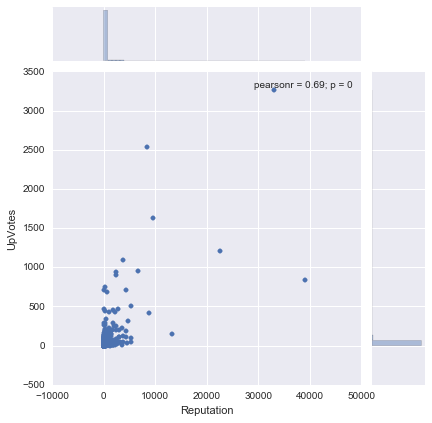

In [25]:
pandas_df = data.sample(False, .1, 42).toPandas()
# %matplotlib qt
sns.jointplot('Reputation', 'UpVotes', data=pandas_df)

Time taken = 0.507575035095 seconds.


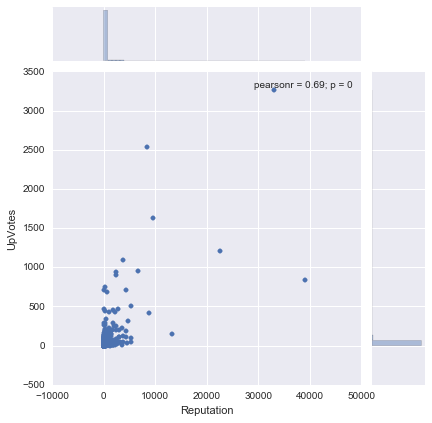

In [26]:
start_time = time()
pandas_df = data.sample(False, .1, 42).toPandas()
%matplotlib inline
sns.jointplot('Reputation', 'UpVotes', data=pandas_df)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 0.942696094513 seconds.


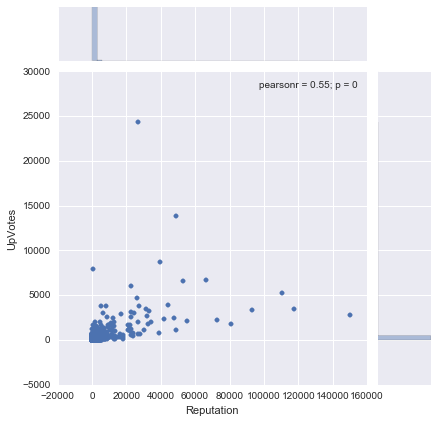

In [27]:
start_time = time()
pandas_df = data.sample(False, 0.9, 42).toPandas()
%matplotlib inline
sns.jointplot('Reputation', 'UpVotes', data=pandas_df)
print ("Time taken =", time() - start_time, "seconds.")

This visualistion is unintutive as most of the data is distributed in a narrow zone and the 
scale is skewed due to outliers. We will try plotting the values on the log scale.

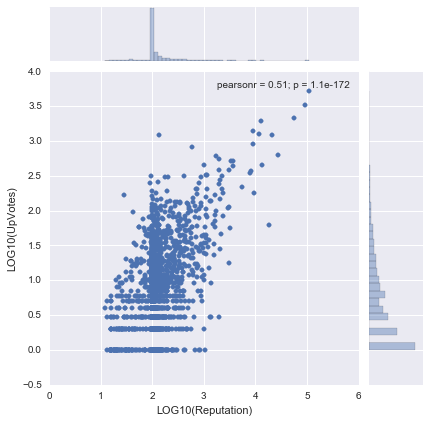

In [28]:
log_pandas_df = data.select(func.log10(data["Reputation"]),func.log10(data["UpVotes"])).sample(False, .1).toPandas()
# %matplotlib qt
sns.jointplot('LOG10(Reputation)', 'LOG10(UpVotes)', data=log_pandas_df)

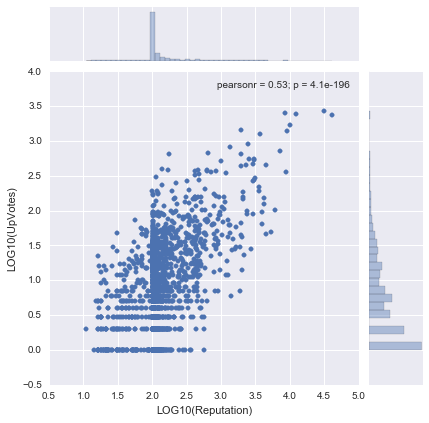

In [29]:
log_pandas_df = data.select(func.log10(data["Reputation"]),func.log10(data["UpVotes"])).sample(False, .1).toPandas()
%matplotlib inline
sns.jointplot('LOG10(Reputation)', 'LOG10(UpVotes)', data=log_pandas_df)

Before we wrap up, let us play with the *CreationDate* column and see if we can mine some interesting observations on that front. The idea is to show how we can play with more complex data types (like datetime)and use some Spark operators as well.

We will start with the *user_df* dataframe. Remember that we had uncached it which means it is no longer available in memory but we can still run operations on it. In this case, the dataframe would be loaded once again but will not be persisted, unless we explicitly ask Spark to do so.

In [30]:
creation_date_df = user_df.select("CreationDate")
creation_date_df.printSchema()
creation_date_df.show(10)

root
 |-- CreationDate: string (nullable = true)

+--------------------+
|        CreationDate|
+--------------------+
|2013-09-13T02:07:...|
|2013-09-13T02:17:...|
|2013-09-13T03:03:...|
|2013-09-13T03:17:...|
|2013-09-13T03:28:...|
|2013-09-13T03:47:...|
|2013-09-13T03:53:...|
|2013-09-13T04:03:...|
|2013-09-13T04:05:...|
|2013-09-13T04:07:...|
+--------------------+
only showing top 10 rows



Note that **CreationDate** column was parsed as **string**. Let us fix that by selecting **CreationDate** as **date** type.

In [31]:
date_df = creation_date_df.select(func.to_date(creation_date_df["CreationDate"]).alias("CreationDate"))
date_df.printSchema()
date_df.show(10)

root
 |-- CreationDate: date (nullable = true)

+------------+
|CreationDate|
+------------+
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
|  2013-09-13|
+------------+
only showing top 10 rows



### RDD vs DataFrame

We want to count the number of new accounts each day. We would try doing this using both RDDs and DataFrames and compare their performance.

### RDD
We want to count the number of new accounts added each day. We first convert our dataframe to rdd. In  data, each row corresponds to one account. So each row contributes one new account. We map each row with neumerical value 1 (number of accounts each row contributes).

Then we reduce our data using date as the key and add the values corresponding to same date.

In [32]:
start_time = time()
aggregated_df = date_df.rdd.map(lambda a: (a, 1)).reduceByKey(operator.add).toDF()
print ("aggregated_df maps each date to number of accounts that were created.")
print ("Number of rows = ",aggregated_df.count())
time_taken_rdd = time() - start_time
print ("Time taken =", time_taken_rdd, "seconds.")

aggregated_df maps each date to number of accounts that were created.
Number of rows =  1985
Time taken = 1.97528195381 seconds.


### DataFrame

In [33]:
start_time = time()
aggregated_df = date_df.groupBy('CreationDate').count()
print ("aggregated_df maps each date to number of accounts that were created.")
print ("Number of rows = ",aggregated_df.count())
time_taken_df = time() - start_time
print ("Time taken =", time_taken_df, "seconds.")

aggregated_df maps each date to number of accounts that were created.
Number of rows =  1985
Time taken = 1.90125417709 seconds.


In [34]:
print ("time_taken_rdd =", time_taken_rdd)
print ("time_taken_df =", time_taken_df)
print ("Speed up =",time_taken_rdd/time_taken_df)

time_taken_rdd = 1.97528195381
time_taken_df = 1.90125417709
Speed up = 1.03893628617


### DataFrames are many times faster than RDDs.

In [35]:
aggregated_df.printSchema()

root
 |-- CreationDate: date (nullable = true)
 |-- count: long (nullable = false)



In [36]:
pandas_df = aggregated_df.select("CreationDate", aggregated_df["count"].alias("NewAccounts"))\
.orderBy(func.asc("CreationDate")).toPandas()
pandas_df

,CreationDate,NewAccounts
0,2010-07-28,154
1,2010-07-29,64
2,2010-07-30,8
3,2010-07-31,3
4,2010-08-02,12
5,2010-08-03,16
6,2010-08-04,147
7,2010-08-05,181
8,2010-08-06,74
9,2010-08-07,29


Let us plot this data and see if there is any interesting observation.

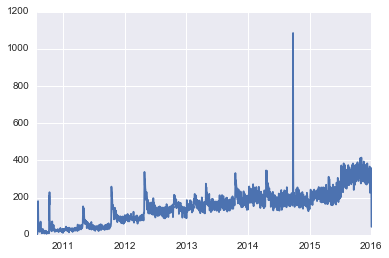

In [37]:
# %matplotlib qt
plt.plot(pandas_df.CreationDate, pandas_df.NewAccounts)

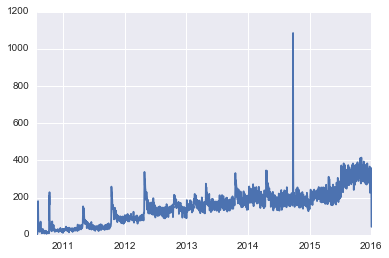

In [38]:
%matplotlib inline
plt.plot(pandas_df.CreationDate, pandas_df.NewAccounts)

Interesting! We can see a spike. If we zoom into the data, we see the date of the spike as 25th September, 2014 when around 1080 new users joined AskUbuntu. A cursory [Google search](https://www.google.com/?q=24th%20september%202014%20ubuntu) reported that [USN-2362-1: Bash vulnerability](http://www.ubuntu.com/usn/usn-2362-1/) was reported on this day.

The other, smaller peaks occur close to release dates of new versions of Ubuntu.